# Introduction
<hr style="border:2px solid black"> </hr>

- **What?** Kaggle competition: House Prices - Advanced Regression Techniques. This particular notebook serves as a common repository to code snippets of my own or taken from other kagglers.

- **Dataset description** Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition’s dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# General info
<hr style="border:2px solid black"> </hr>

- To promote code reusability and tidiness, I will try to bring inside a method most of the actions performed in this notebook.
- If you do not like it, it would extremely easy to get rid of the method and use the content as a code snippet.
- Please, consider this notebooks as a collections of idea taken (and made mine with some modifications) from several notebooks published by other kagglers who generously shared their idea. Here I am returning the favour for the benefit of the others.

# Import modules
<hr style="border:2px solid black"> </hr>

In [ ]:
# Dara wrangling
import pandas as pd
import numpy as np
from collections import Counter
import copy
from functools import reduce
import pandas_profiling as pp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Features engineering
from sklearn.preprocessing import LabelEncoder

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Statistics
from scipy.stats import norm
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from scipy.stats import spearmanr, kendalltau
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Modelling
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, ShuffleSplit, GroupKFold
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor

# ANNS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error as mse_loss
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.layers import LeakyReLU

In [ ]:
# Other notebook settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display as dsp

# Load datasets
<hr style="border:2px solid black"> </hr>

In [ ]:
!ls

In [ ]:
def load_data():   
    """Load data
    
    Load the train and test data as provided by Kaggle.
    Keep in mind that the way Kaggle provide the data is
    different than the usual idea we have of the trian-test
    split. In particular, the target column is not present
    in the test set.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    train - pandas dataframe
    test - pandas dataframe
    """
    
    print("\nLoading data")
    # Read the train data
    print("Read train set")
    train = pd.read_csv('./train_clean.csv')
    # Read the test data
    print("Read test set")
    test = pd.read_csv('./test_clean.csv')
    
    print("Train size", train.shape)
    print("Test size:", test.shape)
    
    train_features = train.columns
    test_features = test.columns       
    print("Not share columns: ", set(train_features).difference(test_features))
    print("Not share columns: ", set(test_features).difference(train_features))
    
    
    return train, test

In [ ]:
# Read data for the first time
df_train, df_test = load_data()

In [ ]:
Id_test = df_test["ID"]
df_test = df_test.drop(columns=["ID"])

In [ ]:
X = df_train.drop(['SalePrice'], axis=1)
y = df_train['SalePrice']

# Sanity checks

In [ ]:
df_train.info

In [ ]:
df_test.info

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

In [ ]:
np.isnan(df_train).sum()

In [ ]:
np.isnan(df_test).sum()

In [ ]:
df_train.describe()

In [ ]:
df_train = df_train.astype(np.float64)
df_test = df_test.astype(np.float64)

# Spot-checking algorithm
<hr style="border:2px solid black"> </hr>

- In this section we'll concentrate on **methods selection**. This is different than model selection beacuse this last concentrate on a single method but is taksed with finding the best model, hence the best instance of the method. It is a nomenclature used in this notebook only.
- Split the train dataset in a ratio 7:3 for modeling.
- For cross-validation scores we can feed the whole dataset as X. The splitting is done inside the kf and then by another function internally which take cares of train and test.
- Please note that we compute the k-Fold once and so to be consistent when compare algorithms.

## How to estabish your method accuracy?

<div class="alert alert-info">
<font color=black>

- **k-Fold CV** is the gold standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10. CV is an approach that you can use to estimate the performance of a ML algorithm with less variance than a single train-test set split. It works by splitting the dataset into k-parts. After running cross validation you end up with k different performance scores that you can summarize using a mean and a standard deviation.

- **Train/test split** is good for speed when using a slow algorithm and produces performance estimates with lower bias when using large datasets. We can take our original dataset and split it into two parts. Train the algorithm on the first part, make predictions on the second part and evaluate the predictions against the expected results. CONS: A downside of this technique is that it can have a high variance. This means that differences in the training and test dataset can result in meaningful differences in the estimate of accuracy.

- **leave-one-out**: You can configure cross validation so that the size of the fold is 1 (k is set to the number of observations in your dataset). This variation of cross validation is called leave-one-out cross validation. The result is a large number of performance measures that can be summarized in an effort to give a more reasonable estimate of the accuracy of your model on unseen data. CONS: A downside is that it can be a computationally more expensive procedure than k-fold cross validation. You can see in the standard deviation that the score has MORE variance than the k-fold cross validation results described above

- **repeated random splits** Another variation on k-fold cross validation is to create a random split of the data like the train/test split described above, but repeat the process of splitting and evaluation of the algorithm multiple times, like cross validation. This has the speed of using a train/test split and the reduction in variance in the estimated performance of k-fold cross validation. CONS: A down side is that repetitions may include much of the same data in the train or the test split from run to run, introducing redundancy into the evaluatio

- **GroupKFold** GroupKFold is a variation of k-fold which ensures that the same group is not represented in both testing and training sets. For example if the data is obtained from different subjects with several samples per-subject and if the model is flexible enough to learn from highly person specific features it could fail to generalize to new subjects. GroupKFold makes it possible to detect this kind of overfitting situations.

- **The bottom line?** If in doubt, use 10-Fold CV.
  
</font>
</div>

<div class="alert alert-info">
<font color=black>

| Methods                           | Type/variation of | Speed                        | Variance                   |
| --------------------------------- | ----------------- | ---------------------------- | -------------------------- |
| Train/test split                  | bare minimum      | Fastest                      | higher than k-fold         |
| k-Fold                            | k-Fold            | Slower than train/test split | less than train/test split |
| Leave-one-out                     | k-Fold            | Slower tha k-Fold            | higher than k-Fold         |
| Repeated Random Test-Train Splits | Train/split       | Slower than train/test split | less than k-Fold           |
| Group k-Fold                      | k-Fold            | ?                            | ?                          |


</font>
</div>

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
def model_scores_on_train_test_splits(model, x_train, y_train, x_test, y_test, verbose=False, fit=True):

    if fit == True:
        # Fit the data only one train set
        model.fit(x_train, y_train)

    # Predict on both test and train. We'll use the test set to
    # see the model generalisation and train to see how much is
    # overfitting.
    test_pred = model.predict(x_test)
    train_pred = model.predict(x_train)

    def _get_metrics(true, predicted):
        mae = metrics.mean_absolute_error(true, predicted)
        mse = metrics.mean_squared_error(true, predicted)
        rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
        r2 = metrics.r2_score(true, predicted)
        if verbose == True:
            print('MAE:', mae)
            print('MSE:', mse)
            print('RMSE:', rmse)
            print('R2', r2)
            print("")
        return mae, mse, rmse, r2

    table = pd.DataFrame()
    table["metrics"] = ["MAE", "MSE", "RMSE", "R2"]

    mae, mse, rmse, r2 = _get_metrics(y_train, train_pred)
    table["Train"] = [mae, mse, rmse, r2]

    mae, mse, rmse, r2 = _get_metrics(y_test, test_pred)
    table["Test"] = [mae, mse, rmse, r2]

    return table

In [ ]:
def get_cv_scores(model, train_set, train_target, name, n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False):
    """Get the CV scores of the model.

    To see the available keys
    sklearn.metrics.SCORERS.keys()

    The loocv does not have R2 because the function returns aNaN. 
    This could be fixed but I have not looked into it.

    Parameters
    ----------
    model : object

    train_set : pandas dataframe
        Matrix contraining instances and features

    train_target : pandas dataframe
        target

    name : string
        name to be used in returns pandas dataframe

    n_splits : int, default=10
        No of splits

    state : int, default=42
        No for the random state pseudo number generator

    test_size : float
        Size of the test set between 0 and 1

    type_ : string, default="k-fold"
        Type of cross-validation used

    verbose : string, default=False
        If True print on screen the results, otherwise it does 
        not print anything on console.

    Returns
    -------
    table : pandas dataframe
        Table containing the mean and std for each metrics.

    split_strategy : iterator
        Iterator used in the call, which can be used to access each fold or
        training set splits.
    """

    print("Type of CV selected", type_)

    # k-Fold
    if type_ == "k-fold":
        scoring = ["neg_mean_absolute_error", "neg_mean_squared_error",
                   "neg_root_mean_squared_error", "r2"]
        metrics_acronyms = ["MAE", "MSE", "RMSE", "R2"]
        split_strategy = KFold(
            n_splits=n_splits, random_state=state, shuffle=True)
        result = cross_validate(model, train_set, train_target,
                                scoring=scoring, cv=split_strategy, n_jobs=-1, return_train_score=True)
    # Repeated train-test
    elif type_ == "repeated_tt":
        scoring = ["neg_mean_absolute_error", "neg_mean_squared_error",
                   "neg_root_mean_squared_error", "r2"]
        metrics_acronyms = ["MAE", "MSE", "RMSE", "R2"]
        split_strategy = ShuffleSplit(
            n_splits=n_splits, test_size=test_size, random_state=state)
        result = cross_validate(model, train_set, train_target,
                                scoring=scoring, cv=split_strategy, n_jobs=-1, return_train_score=True)

    elif type_ == "loocv":
        scoring = ["neg_mean_absolute_error", "neg_mean_squared_error",
                   "neg_root_mean_squared_error"]
        metrics_acronyms = ["MAE", "MSE", "RMSE"]
        split_strategy = LeaveOneOut()
        result = cross_validate(model, train_set, train_target,
                                scoring=scoring, cv=split_strategy, n_jobs=-1, return_train_score=True)

    mean, std = [], []
    for i in scoring:
        if verbose == True:
            print("***********")
            print("Scoring: ", i)
            print("Folds:", [abs(i) for i in result["test_"+i]])
            print("Mean: %.6f" % abs(result["test_"+i].mean()))
            print("Standard deviation: %.6f" % abs(result["test_"+i].std()))
        mean.append(abs(result["test_"+i].mean()))
        std.append(abs(result["test_"+i].std()))

    table = pd.DataFrame()
    table["metrics"] = metrics_acronyms
    table["mean_CV_"+type_+"_"+name] = mean
    table["std_CV_"+type_+"_"+name] = std

    return table, split_strategy

In [ ]:
def visualise_results(model, x_train, x_test, y_train, y_test):
    """Visualise results.

    Given a model fir the model on the train set and
    then resport the result on the test set.
    
    Three plot and then visualise:
    [1] regression plot
    [2] histograme
    [3] qq plot

    """

    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    rcParams['font.size'] = 20

    axs[0].title.set_text('First regression plot')
    dummy = model.fit(x_train, y_train)
    y_pred = pd.Series(dummy.predict(x_test), index=x_test.index, name='Predictions')

    sns.regplot(x=y_test, y=y_pred, color='r', truncate=False, line_kws={
                "color": "k"}, scatter_kws={"s": 3}, ax=axs[0])
    plt.tight_layout()

    axs[2].title.set_text('Histograme')
    sns.histplot([y_test, y_pred], ax=axs[1], color=['r', 'b'])

    axs[2].title.set_text('Quantile')
    sm.ProbPlot(y_test.values).qqplot(ax=axs[2], fmt='r', label='Test')
    sm.ProbPlot(y_pred).qqplot(ax=axs[2], fmt='b', label='Predictions')
    
    plt.legend()
    plt.show()

In [ ]:
def compare_bar_cv_results(dfs):
    """    
    Bar plot of all the rregression metrics.
    """
    
    dfs_ = reduce(lambda left, right: pd.merge(left, right, on='metrics'), dfs)
    
    # Selecting only the mean and not the standard deviation 
    a = [i for i in dfs_.columns if "mean_" in i]
    a.append("metrics")
    a = a[::-1]   
    
    for which_metric in dfs_["metrics"].values:
    

        where = np.where(dfs_["metrics"].values == which_metric)[0][0]

        b = pd.DataFrame(a[1:], columns = ["Regressors"])    
        b[which_metric] = dfs_[a].iloc[where].values[1:]
        if which_metric == "R2":
            b.sort_values(by = [which_metric], inplace = True, ascending=True)
        else:
            b.sort_values(by = [which_metric], inplace = True, ascending=False)

        plt.figure(figsize=(16, 5))
        sns.barplot(b['Regressors'], b[which_metric])        
        plt.ylabel(which_metric, fontsize=18)
        plt.xticks(rotation=90, fontsize=18)
        plt.show()    

In [ ]:
def visual_comparison(models, df, target, model_names=[], log_scale=False, fit_model=True, scaler=None):
    """
    We plot the results only on the test set
    """

    if scaler == None:
        # Split data into train and test sets
        X_train2, X_test2, y_train2, y_test2 = train_test_split(
            df, target, random_state=2, shuffle=True)
    else:
        print("scaling")
        # Split data into train and test sets
        X_train2, X_test2, y_train2, y_test2 = train_test_split(
            scaler.fit_transform(df), target, random_state=2, shuffle=True)
    """
    ss = StandardScaler()
    ss.fit_transform(X)
    ss.inverse_transform()
    """

    rcParams['figure.figsize'] = 17, 8
    rcParams['font.size'] = 15
    fig = plt.figure()

    for i, model in enumerate(models):
        if fit_model == True:
            model.fit(X_train2, y_train2)
        else:
            print("Not fitting the model, assumed it was already fiited!")        
        
        #if scaler == None:
        prediction = model.predict(X_test2)
        #else:
        #    print("scaling back")
        #    prediction = scaler.inverse_transform(model.predict(X_test2))
        
        pred = pd.DataFrame()
        pred["target"] = y_test2
        pred["prediction"] = prediction
        pred["index"] = pred.index
        pred.sort_values(by=['target'], inplace=True)
        if not model_names:
            plt.plot(
                range(len(pred["index"])), pred["prediction"], '-', label=str(model.__class__))
        else:
            plt.plot(range(len(pred["index"])),
                     pred["prediction"], '-', label=model_names[i])

    plt.plot(range(len(pred["index"])), pred["target"],
             '-k', lw=3, label="target")

    plt.xlabel('No of prediction orderd by size')
    plt.ylabel('target')
    plt.legend()
    if log_scale == True:
        plt.yscale('log')
    plt.show()

## Linear regression

- Essentially this is linear regression with no regularisation.

In [ ]:
lr = LinearRegression()

model_scores_on_train_test_splits(lr,
                                  x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_lr, _ = get_cv_scores(
    lr, X, y, name="lr", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lr

In [ ]:
visualise_results(lr, x_train, x_test, y_train, y_test)

- This model may be very sensitive to outliers and this is seems to be true for any linear model. 
- So we need to made it more robust on them. For that we use the sklearn's `Robustscaler()` method on pipeline.
- We are then going to compare the two: scaled vs. not-scaled and see what the difference are.
- One may argue that this was already taken care of but we are also doing an additional step here which is scaling so the imput are between 0 and 1.

- **A note on the scaler.** RobustScaler is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data. Previously i fitted the RobustScaler on both Train and Test set, and that is a mistake on my side. By fitting the scaler on both train and testset, we exposed ourselves to the problem of Data Leakage. Data Leakage is a problem when information from outside the training dataset is used to create the model. If we fit the scaler on both training and test data, our training data characteristics will contain the distribution of our testset. As such, we are unknowningly passing in information about our test data into the final training data for training, which will not give us the opportunity to truly test our model on data it has never seen before. Lesson Learnt: Fit the scaler just on training data, and then transforming it on both training and test data.
- Credit to this [reference](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning).

In [ ]:
lr_scaled = make_pipeline(RobustScaler(), LinearRegression())
model_scores_on_train_test_splits(lr_scaled,
                                  x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
"""
cv_scores_lr_scaled, _ = get_cv_scores(
    lr_scaled, X, y, name="lr_scaled", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lr_scaled
"""

In [ ]:
#visualise_results(lr_scaled, x_train, x_test, y_train, y_test)

- Shall we visualise some preditions?

In [ ]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

rcParams['figure.figsize'] = 17, 8

fig = plt.figure() 
ax = fig.add_subplot(121) 

ax.scatter(y_train_pred, y_train_pred - y_train,
            c="blue", marker="s", label="Training data")
ax.scatter(y_test_pred, y_test_pred - y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.hlines(y=0, xmin=11.5, xmax=12.5, color="red", lw = 3)

ax = fig.add_subplot(122)
plt.scatter(y_train_pred, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_pred, y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.plot([11.5, 12.5], [11.5, 12.5], c="red", lw = 3)

plt.show()

- Errors seem randomly distributed and randomly scattered around the centerline, so there is that at least. It means our model was able to capture most of the explanatory information.

In [ ]:
# Plot important coefficients
coefs = pd.Series(lr.coef_, index = x_train.columns)
print("Linear regression picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("10 most important coefficients in the Linear Regression")
plt.show()

## Bayesian Regression

In [ ]:
br = BayesianRidge(compute_score=True)
model_scores_on_train_test_splits(br,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_br, _ = get_cv_scores(
    br, X, y, name="br", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_br

In [ ]:
visualise_results(br, x_train, x_test, y_train, y_test)

## Lasso

- This is a L1-type regularisation applied to linear regression.
- As pointed out by this [reference](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda) Lasso regressions performs best in the CV RMSE-score. Given the fact that there is a lot of multicolinearity among the variables, this was expected. Lasso does not select a substantial number of the available variables in its model, as it is supposed to do.
- LASSO stands for Least Absolute Shrinkage and Selection Operator. It is an alternative regularization method, where we simply replace the square of the weights by the sum of the absolute value of the weights. In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant

In [ ]:
lasso = linear_model.Lasso()
model_scores_on_train_test_splits(lasso,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_lasso, _ = get_cv_scores(
    lasso, X, y, name="lasso", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lasso

In [ ]:
visualise_results(lasso, x_train, x_test, y_train, y_test)

- How about scaling? In this it brought no benefit and we are not using it.

In [ ]:
lasso_scaled = make_pipeline(RobustScaler(), linear_model.Lasso(alpha=0.1, tol=1e-2))
model_scores_on_train_test_splits(lasso_scaled,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_lasso_scaled, _ = get_cv_scores(
    lasso_scaled, X, y, name="lasso_scaled", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lasso_scaled

In [ ]:
visualise_results(lasso_scaled, x_train, x_test, y_train, y_test)

- But how do we know if the model is overfitting? Taking inspiration from this [reference](https://www.kaggle.com/apapiu/regularized-linear-models), we'll use CV to establish how much is the model overfitting.
- As you can see this model does not seem to benefit too much from regularisation. In fact, no L1 regularisation seems to be OK!

In [ ]:
alphas = [0,  0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50]
rmse_CV_test = []
for alpha_temp in alphas:
    cv_scores_lasso_, _ = get_cv_scores(
        linear_model.Lasso(alpha=alpha_temp), X, y, name="lasso", n_splits=10,
        state=42, test_size=0.25, type_="k-fold", verbose=False)
    rmse_CV_test.append(cv_scores_lasso_["mean_CV_k-fold_lasso"][2])

In [ ]:
cv_ridge = pd.Series(rmse_CV_test, index = alphas)
cv_ridge.plot(title = "CV")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [ ]:
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

rcParams['figure.figsize'] = 17, 8

fig = plt.figure() 
ax = fig.add_subplot(121) 

ax.scatter(y_train_pred, y_train_pred - y_train,
            c="blue", marker="s", label="Training data")
ax.scatter(y_test_pred, y_test_pred - y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red", lw = 3)

ax = fig.add_subplot(122)
plt.scatter(y_train_pred, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_pred, y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.plot([10.5, 13.5], [10.5, 13.5], c="red", lw = 3)

plt.show()

In [ ]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("10 most important coefficients in the Lasso Regression")
plt.show()

- The most interesting thing is that Lasso used only one third of the available features.

## Ridge

- This is a L2 regularisation of linear regression.
- An **L2** penalized model is where we simply add the squared sum of the weights to our cost function.
- From the Python Machine Learning book by Sebastian Raschka : Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting. The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.

In [ ]:
ridge = linear_model.Ridge()
model_scores_on_train_test_splits(ridge,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_ridge, _ = get_cv_scores(
    ridge, X, y, name="ridge", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_ridge

In [ ]:
visualise_results(ridge, x_train, x_test, y_train, y_test)

- **How about scaling?**

In [ ]:
ridge_scaled = make_pipeline(RobustScaler(), linear_model.Ridge())
model_scores_on_train_test_splits(ridge_scaled,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_ridge_scaled, _ = get_cv_scores(
    ridge_scaled, X, y, name="ridge_scaled", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_ridge_scaled

In [ ]:
visualise_results(ridge_scaled, x_train, x_test, y_train, y_test)

- Let's visualise the predictions

In [ ]:
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

rcParams['figure.figsize'] = 17, 8

fig = plt.figure() 
ax = fig.add_subplot(121) 

ax.scatter(y_train_pred, y_train_pred - y_train,
            c="blue", marker="s", label="Training data")
ax.scatter(y_test_pred, y_test_pred - y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red", lw = 3)

ax = fig.add_subplot(122)
plt.scatter(y_train_pred, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_pred, y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.plot([10.5, 13.5], [10.5, 13.5], c="red", lw = 3)

plt.show()

- The very small difference between training and test results indicate that we eliminated most of the overfitting. Visually, the graphs seem to confirm that idea.
- This is because the model is able to learn something from the train data and generaise the result on the test ones.

In [ ]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("10 most important coefficients in the Ridge Regression")
plt.show()

## Kernel Rdige

In [ ]:
kernel_ridge = KernelRidge(alpha=0.1)
model_scores_on_train_test_splits(kernel_ridge,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_kernel_ridge, _ = get_cv_scores(
    kernel_ridge, X, y, name="kernel_ridge", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_kernel_ridge

In [ ]:
visualise_results(kernel_ridge, x_train, x_test, y_train, y_test)

## Polynomial regression

- One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.
- We see that the resulting polynomial regression is in the same class of linear models we’d considered above (i.e. the model is linear in w) and can be solved by the same techniques. By considering linear fits within a higher-dimensional space built with these basis functions, the model has the flexibility to fit a much broader range of data.
- Credit to [reference](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction#%E2%9C%94%EF%B8%8F-Polynomial-Regression)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)

x_train_2d = poly_reg.fit_transform(x_train)
x_test_2d = poly_reg.transform(x_test)

lin_reg_poly = LinearRegression(normalize=True)

In [ ]:
model_scores_on_train_test_splits(lin_reg_poly,
    x_train_2d, y_train, x_test_2d, y_test, verbose=False)

- What is really interesting is that this method is capable to **completely overfit the trainig set**.
- Maybe, if this is properly harnessed it can be used favourably?

In [ ]:
X_2d = poly_reg.fit_transform(X)
cv_scores_kernel_poly_reg, _ = get_cv_scores(
    lin_reg_poly, X_2d, y, name="poly_reg", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_kernel_poly_reg

In [ ]:
#visualise_results(poly_reg, x_train_2d, x_test_2d, y_train, y_test)

## ElasticNet

- ElasticNet is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [ ]:
enet = ElasticNet()
model_scores_on_train_test_splits(enet,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_en, _ = get_cv_scores(
    enet, X, y, name="en", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_en

In [ ]:
y_train_pred = enet.predict(x_train)
y_test_pred = enet.predict(x_test)

rcParams['figure.figsize'] = 17, 8

fig = plt.figure() 
ax = fig.add_subplot(121) 

ax.scatter(y_train_pred, y_train_pred - y_train,
            c="blue", marker="s", label="Training data")
ax.scatter(y_test_pred, y_test_pred - y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red", lw = 3)

ax = fig.add_subplot(122)
plt.scatter(y_train_pred, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_pred, y_test, c="lightgreen",
            marker="s", label="Validation data")

plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc="upper left", fontsize=25)
plt.plot([10.5, 13.5], [10.5, 13.5], c="red", lw = 3)

plt.show()

In [ ]:
# Plot important coefficients
coefs = pd.Series(enet.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("10 most important coefficients in the Elasticnet Regression")
plt.show()

In [ ]:
visualise_results(enet, x_train, x_test, y_train, y_test)

## Stochastic Gradient Descent

- Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. 
- The general idea of Gradient Sescent is to tweak parameters iteratively in order to minimize a cost function. Gradient Descent measures the local gradient of the error function with regards to the parameters vector, and it goes in the direction of descending gradient. 
- Once the gradient is zero, you have reached a minimum.
- Credit to [reference](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction#%E2%9C%94%EF%B8%8F-Polynomial-Regression)

In [ ]:
sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
#sgd_reg = SGDRegressor()

In [ ]:
model_scores_on_train_test_splits(sgd_reg,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
"""
cv_scores_svr_scaled, _ = get_cv_scores(
    sgd_reg, X, y, name="sgd_reg", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_svr_scaled
"""

- This method **did not work** well, so we are not going to plot any additinal information here.

## SVR

- Support Vector Machine can also be used as a regression method, maintaining all the main features that characterize the algorithm (maximal margin). The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. 
- First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. 
- However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.
- Credit to [reference](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction#%E2%9C%94%EF%B8%8F-Polynomial-Regression)

In [ ]:
# Support Vector Regressor
svr_scaled = make_pipeline(RobustScaler(), SVR())

In [ ]:
model_scores_on_train_test_splits(svr_scaled,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_svr_scaled, _ = get_cv_scores(
    svr_scaled, X, y, name="svr_scaled", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_svr_scaled

In [ ]:
visualise_results(svr_scaled, x_train, x_test, y_train, y_test)

## Decision tree

- The decision tree is a simple machine learning model for getting started with regression tasks.
- Background A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a test on an attribute, each branch represents the outcome of a test, and each leaf (or terminal) node holds a class label. The topmost node in a tree is the root node. (see here for more details).

In [ ]:
dtree = DecisionTreeRegressor()
model_scores_on_train_test_splits(dtree,
    x_train, y_train, x_test, y_test, verbose=False)

- What is really interesting is that this method is capable to completely overfit the trainig set. We got the same result under `Polynomial regression`
- Maybe, if this is properly harnessed it can be used favourably?

In [ ]:
cv_scores_dt, _ = get_cv_scores(
    dtree, X, y, name="dt", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_dt

In [ ]:
visualise_results(dtree, x_train, x_test, y_train, y_test)

## Extra tree

In [ ]:
extra_tree = ExtraTreesRegressor()
model_scores_on_train_test_splits(extra_tree,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_et, _ = get_cv_scores(
    extra_tree, X, y, name="extra_t", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_et

In [ ]:
visualise_results(extra_tree, x_train, x_test, y_train, y_test)

## Bagging Regressor

In [ ]:
bgr = BaggingRegressor()
model_scores_on_train_test_splits(bgr,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_bgr, _ = get_cv_scores(
    bgr, X, y, name="bgr", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_bgr

In [ ]:
visualise_results(bgr, x_train, x_test, y_train, y_test)

## Gradient Boosting

In [ ]:
gbm = GradientBoostingRegressor()
model_scores_on_train_test_splits(gbm,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_gbm, _ = get_cv_scores(
    gbm, X, y, name="gbm", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_gbm

In [ ]:
visualise_results(gbm, x_train, x_test, y_train, y_test)

## Random Forest

- A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. 
- What is bagging you may ask? Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.
- Credit to [reference](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction#%E2%9C%94%EF%B8%8F-Polynomial-Regression)

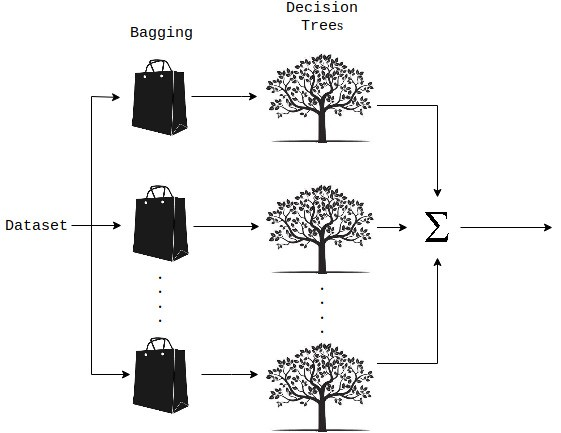

In [ ]:
rf = RandomForestRegressor()

In [ ]:
model_scores_on_train_test_splits(rf,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_rf, _ = get_cv_scores(rf, X, y, name="rf", n_splits=10,
                             state=42, test_size=0.25, type_="k-fold",  verbose=False)
cv_scores_rf

In [ ]:
visualise_results(rf, x_train, x_test, y_train, y_test)

## AdaBoost

In [ ]:
ada = AdaBoostRegressor()
model_scores_on_train_test_splits(ada,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_ada, _ = get_cv_scores(
    ada, X, y, name="ada", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_ada

In [ ]:
visualise_results(ada, x_train, x_test, y_train, y_test)

## Bagging

In [ ]:
br = BaggingRegressor()
model_scores_on_train_test_splits(br,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_br, _ = get_cv_scores(
    br, X, y, name="br", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_br

In [ ]:
visualise_results(br, x_train, x_test, y_train, y_test)

## XGBoost

- Extreme Gradient Boost (XGB) is a boosting algorithm that uses the gradient boosting framework; where gradient descent algorithm is employed to minimize the errors in the sequential model. 
- It improves on the gradient boosting framework with faster execution speed and improved performance.
- Credit to [reference](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning)

In [ ]:
xgb = XGBRegressor(n_jobs=1)
model_scores_on_train_test_splits(xgb,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_xgb, _ = get_cv_scores(
    xgb, X, y, name="xgb", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_xgb

In [ ]:
visualise_results(xgb, x_train, x_test, y_train, y_test)

## CatBoost

- Catboost is another alternative gradient boosting framework developed by Yandex. The word "Catboost" is derived from two words; "Category" and "Boosting". This means that Catboost itself can deal with categorical features which usually has to be converted to numerical encodings in order to feed into traditional gradient boost frameworks and machine learning models.
- The 2 critical features in Catboost algorithm is the use of ordered boosting and innovative algorithm for processing categorical features, which fight the prediction shift caused by a special kind of target leakage present in all existing implementations of gradient boosting algorithms.
- Credit to [reference](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning)

In [ ]:
cat = CatBoostRegressor(verbose = False)
model_scores_on_train_test_splits(cat,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_cat, _ = get_cv_scores(cat, X, y, name="cat", n_splits=10,
                              state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_cat

In [ ]:
visualise_results(cat, x_train, x_test, y_train, y_test)

## LightGBM

- LightBGM is another gradient boosting framework developed by Microsoft that is based on decision tree algorithm, designed to be efficient and distributed. Some of the advantages of implementing LightBGM compared to other boosting frameworks include:

    - Faster training speed and higher efficiency (use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure)
    - Lower memory usage (Replaces continuous values to discrete bins which result in lower memory usage)
    - Better accuracy
    - Support of parallel and GPU learning
    - Capable of handling large-scale data (capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST)

- LightGBM splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. This leaf-wise algorithm reduces more loss than the level-wise algorithm, hence resulting in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.
- Credit to [reference](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning)

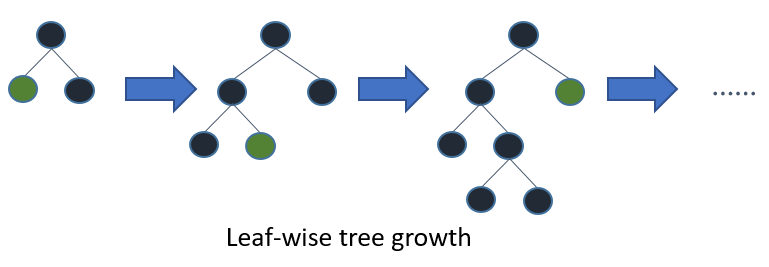

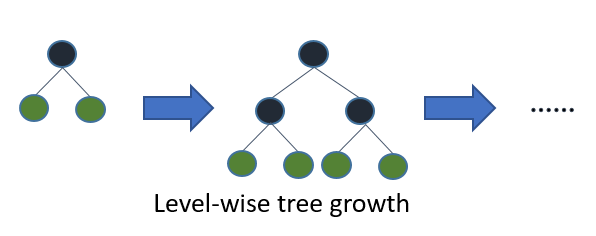

In [ ]:
l_gbm = LGBMRegressor(objective='regression', verbose=0)
model_scores_on_train_test_splits(l_gbm,
    x_train, y_train, x_test, y_test, verbose=0)

In [ ]:
cv_scores_lgbm, _ = get_cv_scores(
    l_gbm, X, y, name="l_gbm", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lgbm

In [ ]:
visualise_results(l_gbm, x_train, x_test, y_train, y_test)

- At this point we have tested a series of methods a lwith their default options.
- We'll compare them and the decide which one we'll use for the stacking method.

In [ ]:
def compare_cv_results(dfs, what = "mean"):    
    """    
    It highlights the best value in each column
    
    Parameters
    ----------
    what : string, default="mean"
        Whether we'd like to filter the result by mean or
        standard deviation
        
    Returns
    -------
    dfs : pandas dataframe
        A highlighted pandas dataframe
    """
    
    dfs_ = reduce(lambda left, right: pd.merge(left, right, on='metrics'), dfs)

    b = []
    def highlight(x):    
        for v in x:
            if v == "R2":
                if what == "mean":
                    return ['background: yellow' if v == max(x[1:]) else '' for v in x]
                else:
                    return ['background: yellow' if v == min(x[1:]) else '' for v in x]
            else:                
                #return ['' for v in x]
                return ['background: yellow' if v == min(x[1:]) else '' for v in x]


    def bold(x):
        for v in x:
            if v == "R2":
                if what == "mean":
                    return ['font-weight: bold' if v == max(x[1:]) else '' for v in x]
                else:
                    return ['font-weight: bold' if v == min(x[1:]) else '' for v in x]
            else:
                return ['font-weight: bold' if v == min(x[1:]) else '' for v in x]

    
    # Selecting only the mean and not the standard deviation 
    
    a = [i for i in dfs_.columns if what + "_" in i]
    a.append("metrics")
    a = a[::-1]
    #dfs_[a]#.T
    #print(dfs_.T.columns)
    #dfs_.T.sort_values(by = [int(3)], inplace = True)    
        
    return dfs_[a].T.style.apply(highlight).apply(bold)

In [ ]:
dfs = [
       cv_scores_lr,
       cv_scores_br,
       cv_scores_lasso,
       cv_scores_lasso_scaled,
       cv_scores_ridge,
       cv_scores_ridge_scaled,
       cv_scores_kernel_ridge,
       cv_scores_kernel_poly_reg,
       cv_scores_et,
       cv_scores_bgr,
       cv_scores_gbm,
       cv_scores_rf,
       cv_scores_ada,
       cv_scores_br,
       cv_scores_xgb,
       cv_scores_cat,
       cv_scores_lgbm
       ]

In [ ]:
compare_cv_results(dfs, what = "mean")

In [ ]:
compare_cv_results(dfs, what = "std")

## Stacking

- The key here is to make the (linear) models robust to outliers. 

- The steps for this technique are shown below:

    - Create a set of algorithms ready for stacking
    - Split the original training data into a training and validation sample 
    - Train the algorithms on the training sample
    - For each algorithm, apply the trained models to the validation dataset and create a set of predictions, 1 column for each model, as a new table. Call this the new training dataset.
    - Also apply the trained algorithm to the test dataset and create a final set of predictions, 1 column for each model, as a new table. Call this new test dataset.
    - For the new training dataset, we have labeled outputs, in the form of Y_test. Now we must train another model on these two feature sets: new training dataset and Y_test.
    - Use this newly trained model to predict values for new test dataset

- Credits to this [reference](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5)

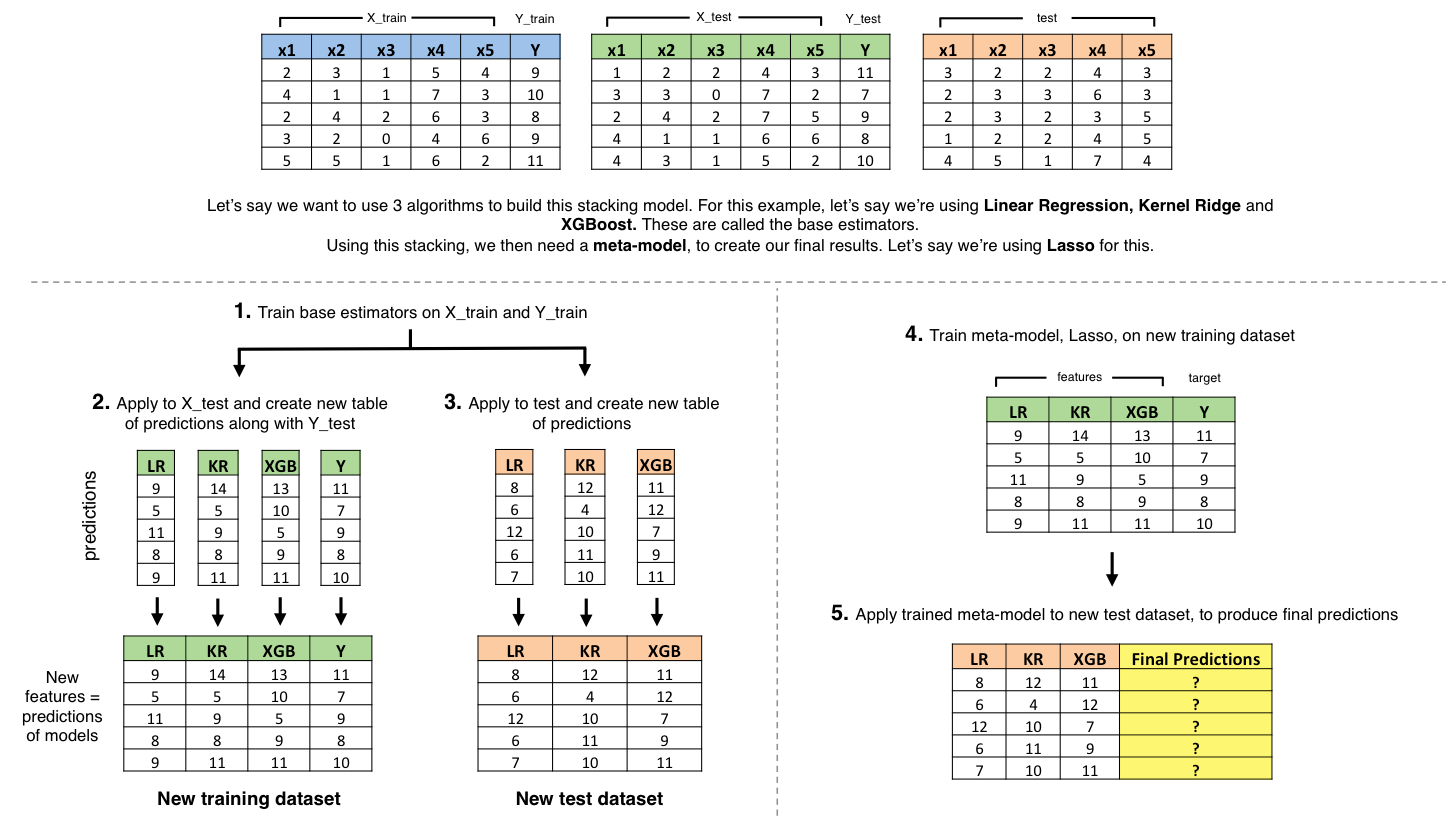

In [ ]:
stack_gen = StackingRegressor(regressors=(XGBRegressor(n_jobs=1), 
                                          CatBoostRegressor(verbose=False),
                                          LGBMRegressor(objective='regression', verbose=0)),
                              meta_regressor=linear_model.Ridge(),
                              use_features_in_secondary=True)

In [ ]:
model_scores_on_train_test_splits(stack_gen,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_stack, _ = get_cv_scores(
    stack_gen, X, y, name="stack", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_stack

In [ ]:
dfs = [
    cv_scores_lr,
    cv_scores_br,
    cv_scores_lasso,
    cv_scores_lasso_scaled,
    cv_scores_ridge,
    cv_scores_ridge_scaled,
    cv_scores_kernel_ridge,
    cv_scores_kernel_poly_reg,
    cv_scores_et,
    cv_scores_bgr,
    cv_scores_gbm,
    cv_scores_rf,
    cv_scores_ada,
    cv_scores_br,
    cv_scores_xgb,
    cv_scores_cat,
    cv_scores_lgbm,
    cv_scores_stack
]

In [ ]:
compare_cv_results(dfs, what = "mean")

In [ ]:
compare_cv_results(dfs, what = "std")

- In this case stacking **did not** improve the CV results.
- We could try other combination between regressor and meta regressor. This seems to be  matter of finding the best combination via some trials and errors.

# Extreme settings

- These are settings found by other kagglers. They are here flagged as extreme as I've assumed they have gone some sort of deep tuning. Of course, this assumption can possibly be plain wrong.
- I am using they all have gone some sort of optimisation and they are here reported for two reasons:
    - They serve as a base for comparison, meaning, can I find they same sort of setting also wth hyper=parameters tuning routune?
    - They serve as a quick indication of how much potential a model has.
- Further, my datacleaning and feature engineering, are very different therefore there is no solid ground as why we should perform such analysis. For me was just a check to probe the model potential. I admit, that potential here will be discover by luck rather than regorous analysis.

## Lasso -> extreme

- This was the taken from [reference](https://www.kaggle.com/roee286/some-lessons-3rd-place-in-leaderboard)

In [ ]:
lasso_extreme = linear_model.Lasso(max_iter=1e6, alpha=5e-4)
model_scores_on_train_test_splits(lasso_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_lasso_ex, _ = get_cv_scores(
    lasso_extreme, X, y, name="lasso_ext", n_splits=10, state=42, test_size=0.25,
    type_="k-fold", verbose=False)
cv_scores_lasso_ex

- Let's now compare this setting against the baseline.

In [ ]:
compare_cv_results([cv_scores_lasso, cv_scores_lasso_ex], what = "mean")

## Extra tree -> extreme

In [ ]:
# Using all features available
extra_tree_extreme = ExtraTreesRegressor(
    n_estimators=3000, max_features=x_train.shape[1])
model_scores_on_train_test_splits(extra_tree_extreme,
                                  x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_et_ext, _ = get_cv_scores(
    extra_tree, X, y, name="extra_t_ext", n_splits=10, state=42, test_size=0.25,
    type_="k-fold", verbose=False)
cv_scores_et_ext

In [ ]:
compare_cv_results([cv_scores_et, cv_scores_et_ext], what = "mean")

## Bagging regressor -> extreme

In [ ]:
br_extreme = BaggingRegressor(n_estimators=3000, max_features=x_train.shape[1])
model_scores_on_train_test_splits(br_extreme,
                                  x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_br_ex, _ = get_cv_scores(
    br, X, y, name="br_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_br_ex

In [ ]:
compare_cv_results([cv_scores_br, cv_scores_br_ex], what = "mean")

## XGBoost -> extreme setting

- This settings were copied from this [reference](https://www.kaggle.com/humananalog/xgboost-lasso).
- There were used to get an idea of how much I should have expanded my hyper-parameters tuning.

In [ ]:
xgb_extreme = XGBRegressor(
    colsample_bytree=0.2,
    gamma=0.0,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=1.5,
    n_estimators=7200,
    reg_alpha=0.9,
    reg_lambda=0.6,
    subsample=0.2,
    seed=42,    
    n_jobs=1)

In [ ]:
model_scores_on_train_test_splits(xgb_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_xgb_ex, _ = get_cv_scores(
    xgb_extreme, X, y, name="xgb_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_xgb_ex

In [ ]:
compare_cv_results([cv_scores_xgb, cv_scores_xgb_ex], what = "mean")

## LightGBM -> extreme

In [ ]:
l_gbm_extreme = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [ ]:
model_scores_on_train_test_splits(l_gbm_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_l_gbm_ex, _ = get_cv_scores(
    l_gbm_extreme, X, y, name="l_gbm_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_l_gbm_ex

In [ ]:
compare_cv_results([cv_scores_lgbm, cv_scores_l_gbm_ex], what = "mean")

## Ridge -> extreme

- I guess what `RidgeCV` does is to select the best value of alphas.

In [ ]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4,
                1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
kf = KFold(n_splits=10, random_state=42, shuffle=True)
ridge_extreme = make_pipeline(
    RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

In [ ]:
ridge_extreme.get_params

In [ ]:
model_scores_on_train_test_splits(ridge_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

- There should not be much difference between the cell above and below because we have used CV already.

In [ ]:
cv_scores_ridge_ex, _ = get_cv_scores(
    ridge_extreme, X, y, name="ridge_ext", n_splits=10, state=42, test_size=0.25,
    type_="k-fold", verbose=False)
cv_scores_ridge_ex

In [ ]:
compare_cv_results([cv_scores_ridge, cv_scores_ridge_ex], what = "mean")

## Gradient Boosting -> extreme

In [ ]:
gbm_extreme = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

In [ ]:
model_scores_on_train_test_splits(gbm_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_gbm_ex, _ = get_cv_scores(
    gbm_extreme, X, y, name="gbm_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_gbm_ex

In [ ]:
compare_cv_results([cv_scores_gbm, cv_scores_gbm_ex], what = "mean")

## Random Forest -> extreme

In [ ]:
rf_extreme = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [ ]:
model_scores_on_train_test_splits(rf_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_rf_ex, _ = get_cv_scores(
    rf_extreme, X, y, name="rf_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_rf_ex

In [ ]:
compare_cv_results([cv_scores_rf, cv_scores_rf_ex], what = "mean")

# CatBoost -> Extreme

- Credits to this [reference](https://www.kaggle.com/marto24/beginners-prediction-top3/notebook)

In [ ]:
params_extreme = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': False,
          'random_seed': 42}

In [ ]:
cat_extreme = CatBoostRegressor(**params_extreme)
model_scores_on_train_test_splits(cat_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_cat_ex, _ = get_cv_scores(cat_extreme, X, y, name="cat_ext", n_splits=10,
                              state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_cat_ex

In [ ]:
compare_cv_results([cv_scores_cat, cv_scores_cat_ex], what = "mean")

## SVR -> extreme

In [ ]:
# Support Vector Regressor
svr_extreme = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

In [ ]:
model_scores_on_train_test_splits(svr_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_svr_ex, _ = get_cv_scores(
    svr_extreme, X, y, name="svr_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_svr_ex

In [ ]:
compare_cv_results([cv_scores_svr_scaled, cv_scores_svr_ex], what = "mean")

## Stacked Regressor -> extreme

In [ ]:
stack_gen_extreme = StackingRegressor(regressors=(xgb_extreme, l_gbm_extreme, cat_extreme),
                                      meta_regressor=ridge_extreme,
                                      use_features_in_secondary=True)

In [ ]:
model_scores_on_train_test_splits(stack_gen_extreme,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_stack_ex, _ = get_cv_scores(
    stack_gen_extreme, X, y, name="stack_ext", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_stack_ex

In [ ]:
compare_cv_results([cv_scores_stack, cv_scores_stack_ex], what = "mean")

## Comparing extreme models

- You now have two alternative to choose the model.
    - Use the score coming from the train and split method.
    - Use the score coming from the CV.
- As a general rule you'd like to have the most robust prediction and this is done by looking at your CV score. This is even more important if your dataet is not huge.

In [ ]:
dfs = [
    cv_scores_lasso_ex,
    cv_scores_et_ext,
    cv_scores_br_ex,
    cv_scores_ridge_ex,
    cv_scores_xgb_ex,
    cv_scores_cat_ex,
    cv_scores_l_gbm_ex,
    cv_scores_gbm_ex,
    cv_scores_rf_ex,
    cv_scores_svr_ex,
    cv_scores_stack_ex
]

- From the table below, we'd like to exclude the less performant model:
    - extra tree
    - bagging regressor
    - support vector
- Keep in mind that were results obtained using tuned parameters taken from others kagglers. As such they come with all sort of problems.

In [ ]:
# Get the best std
compare_cv_results(dfs, what = "mean")

In [ ]:
compare_bar_cv_results(dfs)

In [ ]:
visual_comparison([lasso_extreme, ridge_extreme], X, y, log_scale=False)

In [ ]:
visual_comparison([ridge_extreme, xgb_extreme, cat_extreme,
                  l_gbm_extreme, stack_gen_extreme], X, y, log_scale=False)

## ANN

In [ ]:
# This the imput accepted by Keras
x_train_K = np.array(x_train)
x_test_K = np.array(x_test)
y_train_K = np.array(y_train)
y_test_K = np.array(y_test)

In [ ]:
x_train_K = StandardScaler().fit_transform(x_train_K)
x_test_K = StandardScaler().fit_transform(x_test_K)

In [ ]:
"""
model = Sequential()
model.add(Dense(256, input_dim=x_train_K.shape[1]))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(.1))
model.add(Dense(192, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#"""

In [ ]:
#"""
model = Sequential()

model.add(Dense(x_train_K.shape[1], activation='relu'))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1))

model_ = copy.deepcopy(model)
model_CV = copy.deepcopy(model)
#"""

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [ ]:
#model.compile(optimizer=Adam(0.00001), loss='mse', metrics=[root_mean_squared_error])
model_.compile(optimizer=Adam(0.0001), loss='mse', metrics=[root_mean_squared_error])

In [ ]:
r = model_.fit(x_train_K, y_train_K,
              validation_data=(x_test_K, y_test_K),
              batch_size=1,
              epochs=100,
              callbacks=[EarlyStopping(patience=50, verbose=1)])

In [ ]:
pd.DataFrame(r.history).plot.line(y=['loss', 'val_loss'])

In [ ]:
# we do not want to fit model again!
model_scores_on_train_test_splits(model_,
                                  x_train_K, y_train_K, x_test_K, y_test_K, verbose=False, fit=False)

- To CV the results for this ANNs, I'd suggest using only two splits because of the time taken to fit the whole model is much longer than the others models seen before.
- This is obviously should not be used as an excuse for not properly validating the model, so if you the time increase the n_split to at leat 5.

In [ ]:
def get_cv_scores_custom(models, train_set, train_target, n_splits=10,
                         state=42, test_size=0.25, name="dummy", type_="k-fold", verbose=False):
    """Get the CV scores of a blending model.

    The blending is done via weights. These impose the level of importance
    each model has on the prediction of the final solution.

    Parameters
    ----------
    models : list of model object
        It is assumed the model paramaters have already been defined
        and the fitting is th only thing done inside this method.        

    train_set : pandas dataframe
        Matrix contraining instances and features

    train_target : pandas dataframe
        target

    name : string
        name to be used in returns pandas dataframe

    n_splits : int, default=10
        No of splits

    state : int, default=42
        No for the random state pseudo number generator

    test_size : float
        Size of the test set between 0 and 1

    type_ : string, default="k-fold"
        Type of cross-validation used

    verbose : string, default=False
        If True print on screen the results, otherwise it does 
        not print anything on console.

    Returns
    -------
    table : pandas dataframe
        Table containing the mean and std for each metrics.

    """

    def _get_model_scores_on_test_splits(models, x_train, y_train, x_test, y_test, verbose=False):

        # Predict on both test and train. We'll use the test set to
        # see the model generalisation and train to see how much is
        # overfitting.
        model.compile(optimizer=Adam(0.0001), loss='mse', metrics=[root_mean_squared_error])
        model.fit(x_train, y_train,
                  validation_data=(x_test, y_test),
                  batch_size=1,
                  epochs=100,
                  callbacks=[EarlyStopping(patience=50, verbose=1)],
                  verbose=False)

        test_pred = model.predict(x_test)
        train_pred = model.predict(x_train)

        def _get_metrics(true, predicted):
            mae = metrics.mean_absolute_error(true, predicted)
            mse = metrics.mean_squared_error(true, predicted)
            rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
            r2 = metrics.r2_score(true, predicted)
            if verbose == True:
                print('MAE:', mae)
                print('MSE:', mse)
                print('RMSE:', rmse)
                print('R2', r2)
                print("")
            return mae, mse, rmse, r2

        mae, mse, rmse, r2 = _get_metrics(y_train, train_pred)
        train_results = [mae, mse, rmse, r2]

        mae, mse, rmse, r2 = _get_metrics(y_test, test_pred)
        test_results = [mae, mse, rmse, r2]

        results = {}
        results["train"] = train_results
        results["test"] = train_results
        return results

    print("Type of CV selected", type_)

    # k-Fold
    if type_ == "k-fold":
        scoring = ["neg_mean_absolute_error", "neg_mean_squared_error",
                   "neg_root_mean_squared_error", "r2"]
        metrics_acronyms = ["MAE", "MSE", "RMSE", "R2"]
        split_strategy = KFold(
            n_splits=n_splits, random_state=state, shuffle=True)

        # Enumerate splits
        result = []
        counter = 0
        for index_train, index_test in split_strategy.split(train_set):
            counter += 1
            #print("Evaluation", counter)
            #x_train = train_set.iloc[index_train]
            x_train = train_set[index_train]
            #x_test = train_set.iloc[index_test]
            x_test = train_set[index_test]

            #y_train = train_target.iloc[index_train]
            y_train = train_target[index_train]
            #y_test = train_target.iloc[index_test]
            y_test = train_target[index_test]

            dummy = _get_model_scores_on_test_splits(
                models, x_train, y_train, x_test, y_test, verbose=False)
            result.append(dummy)

        mae_test, mae_train = [], []
        mse_test, mse_train = [], []
        rmse_test, rmse_train = [], []
        r2_test, r2_train = [], []

        for SET in result:
            mae_test.append(SET["test"][0])
            mae_train.append(SET["train"][0])

            mse_test.append(SET["test"][1])
            mse_train.append(SET["train"][1])

            rmse_test.append(SET["test"][2])
            rmse_train.append(SET["train"][2])

            r2_test.append(SET["test"][3])
            r2_train.append(SET["train"][3])

        #table = pd.DataFrame()
        #table["metrics"] = ["MAE", "MSE", "RMSE", "R2"]

        # table["Train"] = [np.array(mae_train).mean(), np.array(
        #    mse_train).mean(), np.array(rmse_train).mean(), np.array(r2_train).mean()]

        # table["Test"] = [np.array(mae_test).mean(), np.array(
        #    mse_test).mean(), np.array(rmse_test).mean(), np.array(r2_test).mean()]

    # Repeated train-test
    else:
        print("not implementened")

    # We're going to report only the CV test score.
    mean, std = [], []
    for i in range(len(metrics_acronyms)):
        folds = [abs(SET["test"][i]) for SET in result]
        mean_temp = np.array([abs(SET["test"][i]) for SET in result]).mean()
        std_temp = np.array([abs(SET["test"][i]) for SET in result]).std()

        mean.append(mean_temp)
        std.append(std_temp)

    table = pd.DataFrame()
    table["metrics"] = metrics_acronyms
    table["mean_CV_"+type_+"_"+name] = mean
    table["std_CV_"+type_+"_"+name] = std

    return table, split_strategy

In [ ]:
cv_scores_ann, _ = get_cv_scores_custom(model_CV, x_train_K, y_train_K, n_splits=2)

In [ ]:
cv_scores_ann

- ANNs is not fairing very well and probably my choiche of architecture is not great.
- I could have spent more time changing the model, but I am dtopping this due to time constraint.

# Features stacking

- At this point we have spot checked a series of model. All of them are probably neither tuned nor properly fitted (meaning, they are likley to overfit).
- With this in mind we can still see how a a single model would behave if it a feature is to be added one by one.
- The way the feature are added follow the correlaction matrix study before. This is by no-means a comprehensive study and serve just as an example on how the model behaves.


In [ ]:
print("Find most important features relative to target")
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice.index)

In [ ]:
features_order_by_importance = corr.SalePrice.index

In [ ]:
df_stacking = pd.concat([df_train, df_test], axis=0)

In [ ]:
train = df_train
test = df_test

In [ ]:
def incremental_feature_modelling(df, features, score_name, model, validation_type):
    """Incremental feature modelling

    This methods add one feature one-by-one starting from 
    the most important to the least important. The user can
    follows one metric at the time.

    Parameters
    ----------
    df : pandas dataframe
        It is the union of both train and test sets.

    features : pandas dataframe
        It is order by the most important to the least important.
        features.
    score : string
        Name of the scoring variable you want to follow.

    model : object
        Name of the model to be used. Must have a fit method

    validation_type : string
        Type of validation when reporting the CV result. An
        example is k-fold

    Returns
    -------
    dfs : pandas dataframe
        Dataframe containing the results. 
    """

    dfs = pd.DataFrame()
    score = []
    no = []
    std = []
    feature_added = []
    selected_features = ["SalePrice"]
    for i in features:
        if i != "SalePrice":
            selected_features.append(i)
            # print(len(features))
            # print(selected_features)
            dff = df[selected_features]
            dff = pd.get_dummies(dff)

            df_train = dff.iloc[:train.shape[0], :]
            df_test = dff.iloc[train.shape[0]:, :]
            print(train.shape, df_train.shape)
            print(test.shape, df_test.shape)

            # Getting the feature and the target
            X = df_train.drop(['SalePrice'], axis=1)
            y = df_train['SalePrice']
            df_test = df_test.drop(['SalePrice'], axis=1)

            print("Adding feature", i, " No of features: ",
                  len(selected_features)-1, " encoded No: ", dff.shape[1])

            # Modelling
            cv_scores_xgb, _ = get_cv_scores(
                model, X, y, name="dummy", n_splits=10, state=42, test_size=0.25,
                type_=validation_type, verbose=False)
            dsp(cv_scores_xgb)

            where = np.where(
                cv_scores_xgb["metrics"].values == score_name)[0][0]
            score.append(cv_scores_xgb.iloc[where]["mean_CV_k-fold_dummy"])
            std.append(cv_scores_xgb.iloc[where]["std_CV_k-fold_dummy"])

            no.append(len(selected_features)-1)
            feature_added.append(i)
            print("_____________________________________")
            print("*************************************")
            print("-------------------------------------")
    dfs["no"] = no
    dfs["CV_mean_"+score_name] = score
    dfs["CV_std_"+score_name] = std
    dfs["feature_added"] = feature_added

    return dfs

In [ ]:
results_features_stacking = incremental_feature_modelling(
    df_stacking, features_order_by_importance, "RMSE", xgb, "k-fold")

In [ ]:
results_features_stacking

- As we can see sometimes we should stop adding features!

In [ ]:
plt.figure(figsize=(16, 24))
sns.barplot(x=results_features_stacking['CV_mean_RMSE'],
            y=results_features_stacking["feature_added"])
#plt.xticks(rotation=90, fontsize=18)

# Plot the score reach by the last value
plt.axvline(x=results_features_stacking['CV_mean_RMSE'].iloc[
    -1], color='k', linestyle='--', lw=3, label='Reference line')
plt.show()

- How does this graph if I reshuffle the order?

In [ ]:
features_order_by_importance

- How can we reshuffle this in an idiomatic way in pandas?
- The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).

In [ ]:
features_order_by_importance_re = pd.DataFrame(features_order_by_importance)
features_order_by_importance_re = features_order_by_importance_re.sample(frac=1)
features_order_by_importance_re = features_order_by_importance_re.values

In [ ]:
features_order_by_importance_re = [i[0] for i in features_order_by_importance_re]
features_order_by_importance_re

In [ ]:
results_features_stacking_re = incremental_feature_modelling(
    df_stacking, features_order_by_importance_re, "RMSE", xgb, "k-fold")

In [ ]:
plt.figure(figsize=(16, 24))
sns.barplot(x=results_features_stacking_re['CV_mean_RMSE'],
            y=results_features_stacking_re["feature_added"])
#plt.xticks(rotation=90, fontsize=18)

# Plot the score reach by the last value
plt.axvline(x=results_features_stacking_re['CV_mean_RMSE'].iloc[
    -1], color='k', linestyle='--', lw=3, label='Reference line')
plt.show()

- The final result will obvisuly not changed, however what may change is the relative delta improvement in performance when each feature is added.

# Hyperparamter tuning

- In **Grid Search**, we set up a grid of hyperparameters and train/test our model on each of the possible combinations. 
- In **Random Search**, we create a grid of hyperparameters and train/test our model on just some random combination of these hyperparameters.

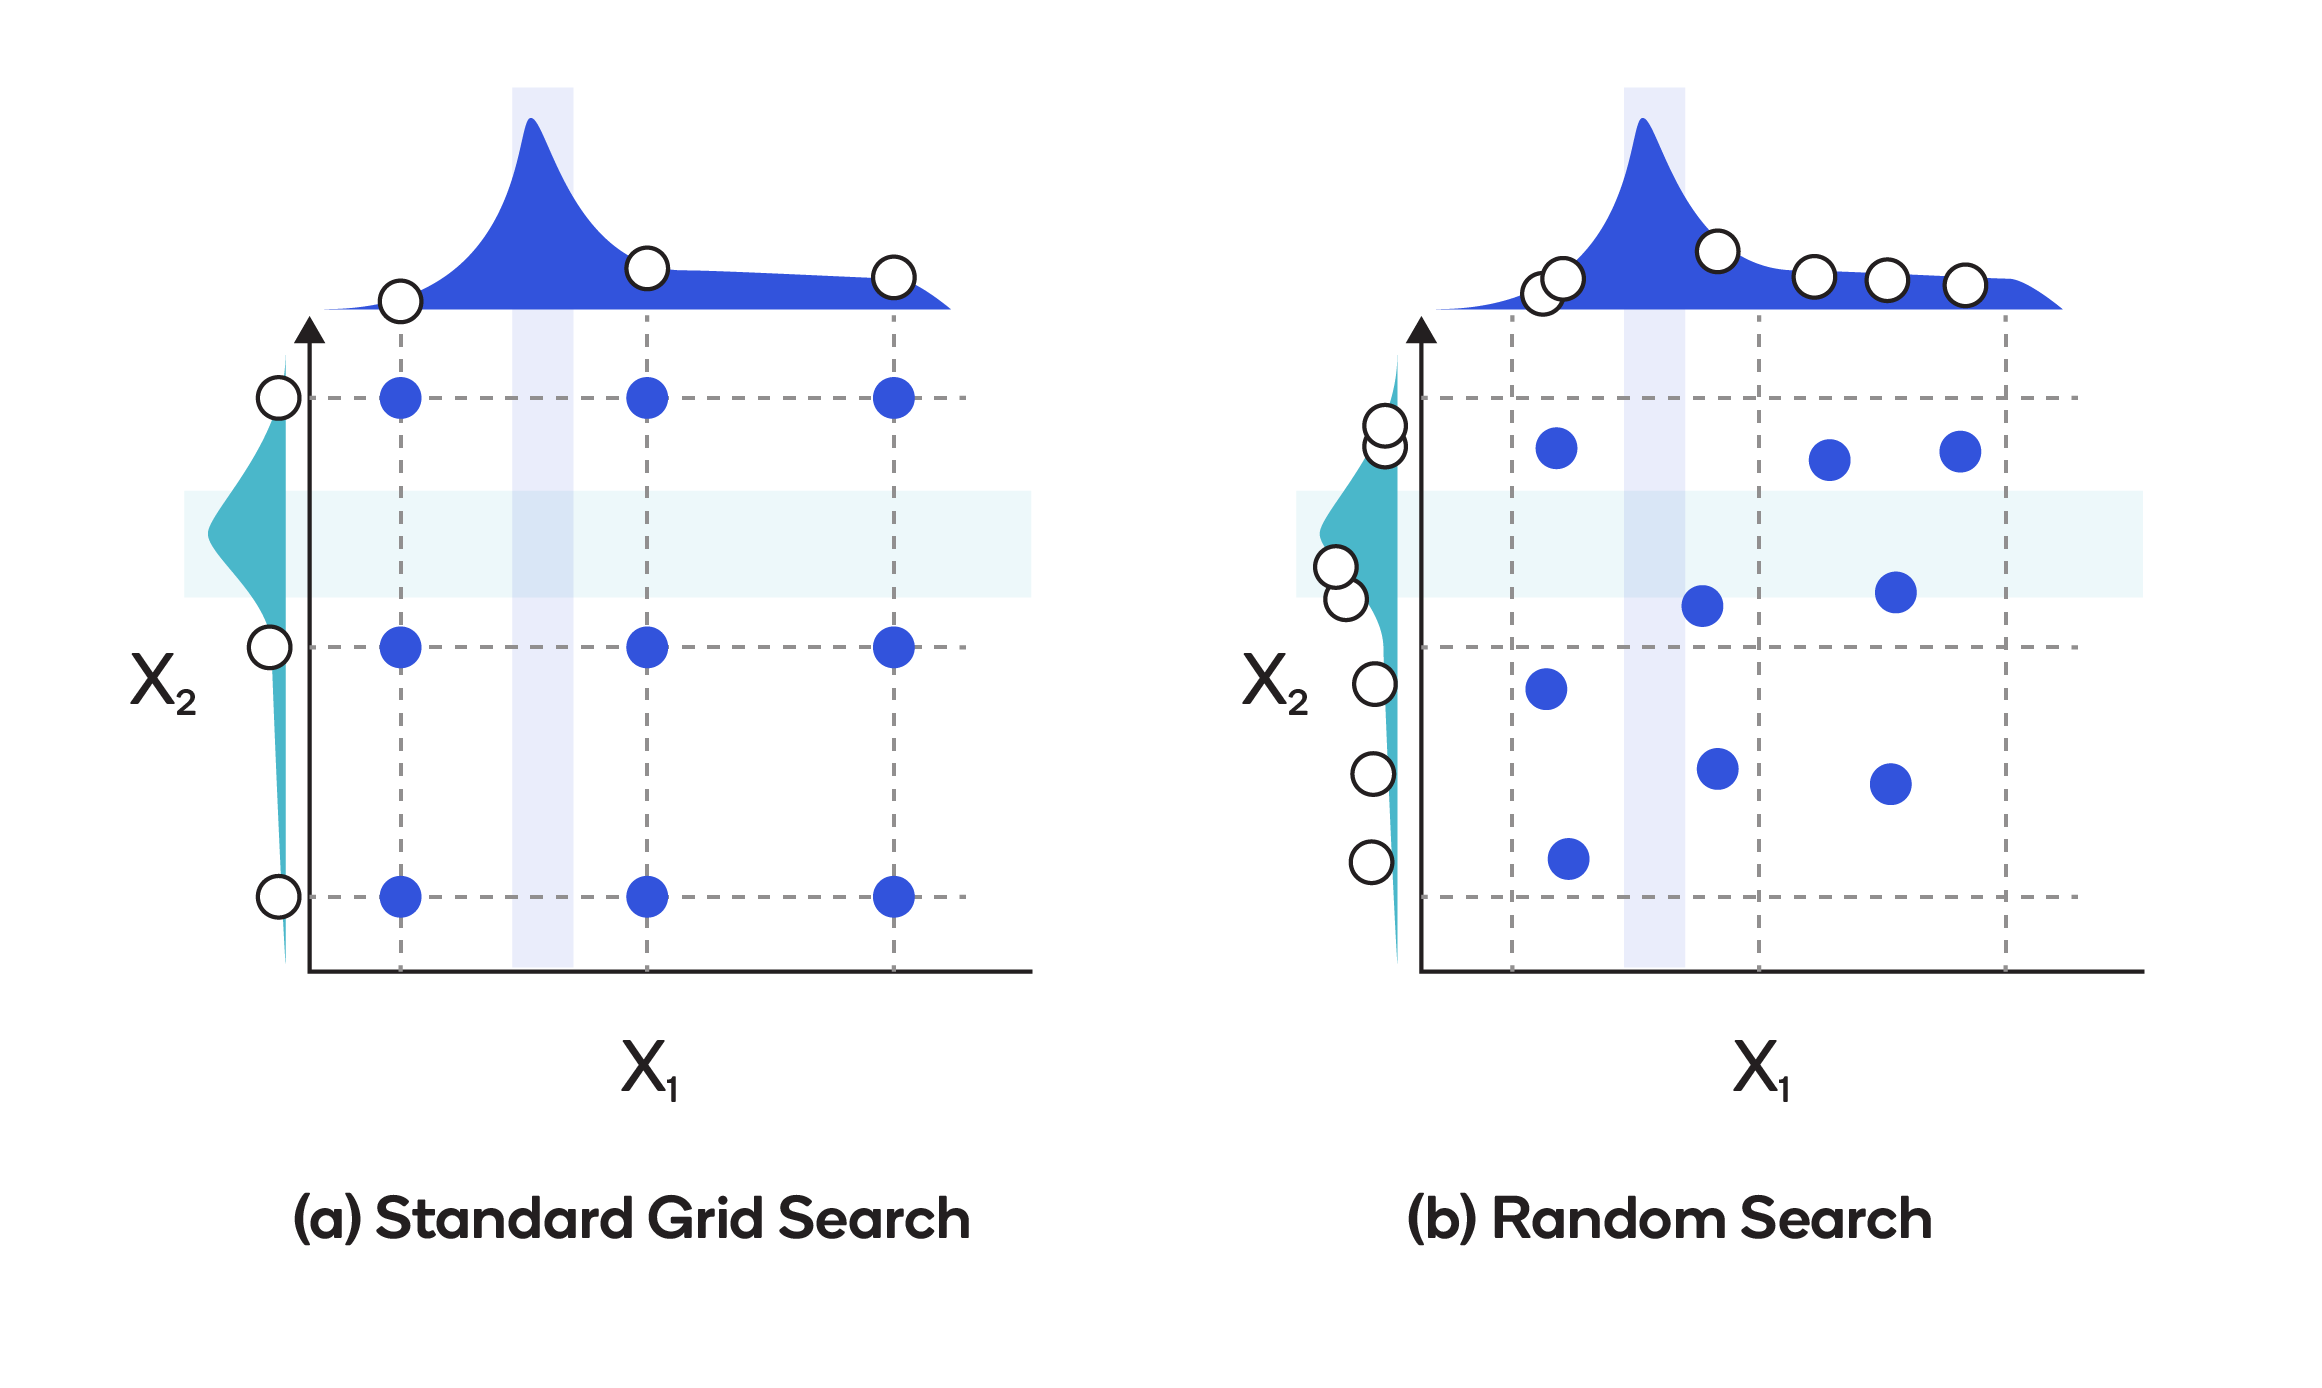

In [ ]:
def grid_search(model, params, kf, df, target, score, n_iter=10, random=False):
    """hyperparamters search
    
    Perform hyperparamter tuning on a given CV sets
    
    Parameters
    ----------
    model - object
    params - dictionary
    kf - iterator
    df - pandas daraframe
    target - pandas dataframe
    score - string
    n_iter : int, default=10
        Number of test performed by the random search.
        If random=Flase this is ignored.
    random : Bool, default=False
    
    Returns
    -------
    grid.best_params_ - dictionary
        Dictionary of the best parameters
    """

    # Create folds -> take of sample subdivision to get average
    #kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

    # Chose the values to be searched in each folder selected above
    if random:
        grid = RandomizedSearchCV(
            model, params, n_iter=10, n_jobs=-1, random_state=2, scoring=score, cv=kf)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model, params, cv=kf, n_jobs=-1, scoring=score)

    # Fit grid_reg on X_train and y_train
    grid.fit(df, target)

    # summarize results
    print("Best score: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("Mean= %f std =%f with: %r" % (mean, stdev, param))
        
    return grid.best_params_

In [ ]:
# Used for all the tuning
split_strategy = KFold(n_splits=10, random_state=42, shuffle=True)

## XGBoost

- You will see how in this case, the small design space I've chosen is not able to bit the score obtained by the _extreme case.
- This is totally expected and one solution could to expand the search design space in `params` dictionary.
- Another solution, could be to use a truly "global algorithm" such as GA.

In [ ]:
params = {'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5],
          'n_estimators': [100, 500, 1000, 2000, 3000],
          'max_depth': [3, 6, 9],
          'min_child_weight': [1, 5, 10, 20],
          'reg_alpha': [0.001, 0.01, 0.1],
          'reg_lambda': [0.001, 0.01, 0.1],
          'subsample': [0.75, 1.0]
          }

best_param = grid_search(XGBRegressor(n_jobs=1), params, split_strategy, X, y,
                         "neg_root_mean_squared_error", n_iter=100, random=True)

In [ ]:
print(best_param)

In [ ]:
# You have to add this otherwise it will crash
best_param["n_jobs"] = 1
xgb_tuned = XGBRegressor(**best_param)
xgb_tuned.get_params

In [ ]:
model_scores_on_train_test_splits(xgb_tuned,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_xgb_tuned, _ = get_cv_scores(
    xgb_tuned, X, y, name="xgb_tuned", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_xgb_tuned

In [ ]:
cv_scores_xgb_tuned

In [ ]:
compare_cv_results([cv_scores_xgb, cv_scores_xgb_ex, cv_scores_xgb_tuned], what = "mean")

In [ ]:
# Get the best std
compare_cv_results([cv_scores_xgb, cv_scores_xgb_ex, cv_scores_xgb_tuned], what = "std")

In [ ]:
visual_comparison([xgb, xgb_extreme, xgb_tuned], X, y,
                  model_names=["xgb_base", "xbg_ext", "xgb_tuned"])

## CatBoost

- You will see how in this case, the small design space I've chosen is not even able to improve the baseline score, a sign that I have really constrained the 
- This is totally expected and one solution could to expand the search design space in `params` dictionary.
- Another solution, could be to use a truly "global algorithm" such as GA.

In [ ]:
try_this_instead = {
    'n_estimators' : [100, 300, 500, 1000, 2000, 3000],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

In [ ]:
params = {'subsample': [0.75, 1.0],
          'learning_rate': [0.15, 0.2, 0.3],
          'max_depth': [2, 3, 4, 5],
          'n_estimators': [100, 500, 1000]
          }

best_param_cat = grid_search(CatBoostRegressor(verbose=False), params, split_strategy, X, y,
                         "neg_root_mean_squared_error", random=True)

In [ ]:
print(best_param_cat)

In [ ]:
best_param_cat["verbose"] = False

In [ ]:
cat_tuned = CatBoostRegressor(**best_param_cat)

In [ ]:
cat_tuned.get_params()

In [ ]:
model_scores_on_train_test_splits(cat_tuned,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_cat_tuned, _ = get_cv_scores(
    cat_tuned, X, y, name="cat_tuned", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_cat_tuned

In [ ]:
compare_cv_results([cv_scores_cat, cv_scores_cat_ex, cv_scores_cat_tuned])

In [ ]:
# Get the best std
compare_cv_results([cv_scores_cat, cv_scores_cat_ex,
                   cv_scores_cat_tuned], what="std")

In [ ]:
visual_comparison([cat, cat_extreme, cat_tuned], X, y, model_names=[
                  "cat_base", "cat_ext", "cat_tuned"], log_scale=False)

## LightGBM

- You will see how in this case, the small design space I've chosen is not able to improve the extreme score, a sign that I have really constrained the design space too much.
- This is totally expected and one solution could to expand the search design space in `params` dictionary.
- Another solution, could be to use a truly "global algorithm" such as GA.

In [ ]:
new_list_try_this_ONE = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 2000, 3000],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

In [ ]:
params = {'subsample': [0.75, 1.0],
          'learning_rate': [0.15, 0.2, 0.3],
          'max_depth': [2, 3, 4, 5],
          'n_estimators': [100, 500, 1000]
          }

best_param_lgbm = grid_search(LGBMRegressor(objective='regression', verbose=0), params, split_strategy, X, y,
                         "neg_root_mean_squared_error", random=True)

In [ ]:
print(best_param_lgbm)

In [ ]:
best_param_lgbm["verbose"] = 0

In [ ]:
lgbm_tuned = LGBMRegressor(objective='regression', **best_param_lgbm)

In [ ]:
lgbm_tuned.get_params()

In [ ]:
model_scores_on_train_test_splits(lgbm_tuned,
    x_train, y_train, x_test, y_test, verbose=False)

In [ ]:
cv_scores_lgbm_tuned, _ = get_cv_scores(
    lgbm_tuned, X, y, name="lgbm_tuned", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_lgbm_tuned

In [ ]:
compare_cv_results([cv_scores_lgbm, cv_scores_l_gbm_ex, cv_scores_lgbm_tuned])

In [ ]:
compare_cv_results([cv_scores_lgbm, cv_scores_l_gbm_ex,
                   cv_scores_lgbm_tuned], what="std")

In [ ]:
visual_comparison([l_gbm, l_gbm_extreme, lgbm_tuned], X, y, model_names=[
                  "lgbm_base", "lgbm_ex", "lgbm_tuned"], log_scale=False)

## Ridge

- We can see how the tuned model performs slighlty better than the extreme model.

In [ ]:
params = {'alpha': [0.01,0.1,0.25,0.5,1.0,2.5,5.0,6.0]
          }

best_param_ridge = grid_search(linear_model.Ridge(), params, split_strategy, X, y,
                         "neg_root_mean_squared_error", random=False)

In [ ]:
ridge_tuned = linear_model.Ridge(**best_param_ridge)

In [ ]:
cv_scores_ridge_tuned, _ = get_cv_scores(
    ridge_tuned, X, y, name="ridge_tuned", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_ridge_tuned

In [ ]:
compare_cv_results([cv_scores_ridge, cv_scores_ridge_ex, cv_scores_ridge_tuned])

In [ ]:
# Get the best std
compare_cv_results([cv_scores_ridge, cv_scores_ridge_ex,
                   cv_scores_ridge_tuned], what="std")

In [ ]:
visual_comparison([ridge, ridge_extreme, ridge_tuned], X, y, model_names=[
                  "ridge_base", "ridge_ex", "ridge_tuned"], log_scale=False)

## Stocked tuned

- In this case it seems that stacking the baseline model works better than both tuned and extreme!

In [ ]:
stack_gen_tuned = StackingRegressor(regressors=(xgb_tuned, cat_tuned, lgbm_tuned, ridge_tuned),
                                    meta_regressor=ridge_tuned,
                                    use_features_in_secondary=True)

In [ ]:
cv_scores_stack_tuned, _ = get_cv_scores(
    stack_gen_tuned, X, y, name="stack_tuned", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_stack_tuned

In [ ]:
compare_cv_results([cv_scores_stack, cv_scores_stack_ex,
                   cv_scores_stack_tuned])

In [ ]:
visual_comparison([stack_gen, stack_gen_extreme, stack_gen_tuned], X, y, model_names=[
                  "stack_base", "stack_ex", "stack_tuned"], log_scale=False)

## Comparing tuned the models

In [ ]:
compare_cv_results([cv_scores_xgb_tuned, cv_scores_cat_tuned, cv_scores_ridge_tuned, cv_scores_lgbm_tuned,
                   cv_scores_stack_tuned])

In [ ]:
compare_cv_results([cv_scores_xgb_tuned, cv_scores_cat_tuned, cv_scores_ridge_tuned, cv_scores_lgbm_tuned,
                   cv_scores_stack_tuned], what="std")

In [ ]:
visual_comparison([xgb_tuned, cat_tuned, ridge_tuned, lgbm_tuned, stack_gen_tuned], X, y, model_names=[
                  "xgb_tuned", "cat_tuned", "ridge_tuned", "lgbm_tuned", "stack_tuned"], log_scale=False)

## Automated hyperparameters

- Below is a link to another notebook shared by one kaggler using automatic hyperparameter tuning
- https://www.kaggle.com/pavansanagapati/automated-hyperparameter-tuning

# Averaging the tuned model

- Simplest Stacking approach : Averaging base models. We'll build a new class that has a fit and preduct method so as to levergae the extensability provided by scikit-learn. Essentially this is a pure averaging of the models
- Please note how the class is built and how we are going to make use of the inheritance.
- Credit for the code to interface with scikitlearn to [link](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard#Modelling)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
# average = AveragingModels(models = (xgb_tuned, cat_tuned, lgbm_tuned, stack_gen_tuned))
average = AveragingModels(models=(
    lasso_extreme,
    ridge_extreme,
    xgb_extreme,
    cat_extreme,
    l_gbm_extreme,
    gbm_extreme,
    rf_extreme
))

In [ ]:
cv_scores_average, _ = get_cv_scores(
    average, X, y, name="average", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=True)
cv_scores_average

- We'll now compare the best between the tune and extreme models **against** the mean model.
- The average model was obtained, as the name suggested, by simply averaging the predictions of all the models.

In [ ]:
compare_cv_results([cv_scores_cat_ex, cv_scores_average])

In [ ]:
visual_comparison([cat_extreme, average], X, y, model_names=[
                  "cat_tuned", "avergae"], log_scale=False)

# Blending the tuned mdel

- This a very simple weighted model.
- Blending is a technique that give different weightage to different algorithms that will affect their influence of the predictions. 
- Such techniques can help to improve performance since it uses a variety of models as predictors.
- The table below wiil help us chose the weights. The rational is the following, the better the CV score the higher the weight. For this task just look at **RMSE** score as this is what Kaggle uses to score you on the leaderboard.

In [ ]:
compare_cv_results([    
    cv_scores_xgb_ex,
    cv_scores_cat_ex,
    cv_scores_l_gbm_ex,
    cv_scores_gbm_ex,    
    cv_scores_stack_ex,
    cv_scores_average
]
, what = "mean")

In [ ]:
"""
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))
            
def blend_models_predict(X):
    return ((0.025* elasticnet_final.predict(X)) + \
            (0.025 * lasso_final.predict(X)) + \
            (0.025 * ridge_final.predict(X)) + \
            (0.025* svr_final.predict(X)) + \
            (0.62 * gbr_final.predict(X)) + \
            (0.03 * xgb_final.predict(X)) + \
            (0.03 * lgbm_final.predict(X)) + \
            (0.22 * stack_reg_final.predict(np.array(X)))) 
"""

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class BlendingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        #"""
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        #return np.mean(predictions, axis=1)        
        #return np.average(predictions, axis=1, weights = self.weights)
        return np.average(predictions, axis=1, weights = self.weights)

In [ ]:
compare_cv_results([    
    cv_scores_xgb_ex,
    cv_scores_cat_ex,    
    cv_scores_gbm_ex,        
    cv_scores_average
]
, what = "mean")

In [ ]:
blend = BlendingModels(
    models=(
            average,
            xgb_extreme, 
            cat_extreme,            
            gbm_extreme,            
           ),
weights = [0.5, 0.3, 0.1, 0.1])

In [ ]:
cv_scores_blend, _ = get_cv_scores(
    blend, X, y, name="blend", n_splits=10, state=42, test_size=0.25, type_="k-fold", verbose=False)
cv_scores_blend

In [ ]:
compare_cv_results([
    cv_scores_average,
    cv_scores_blend
]
, what = "mean")

In [ ]:
visual_comparison([average, blend], X, y, model_names=[
                  "avergae", "blend"], log_scale=False)

# Stacking custom model

- see this link https://www.kaggle.com/pavansanagapati/ensemble-learning-techniques-tutorial

# Final models comparison

In [ ]:
compare_cv_results([cv_scores_xgb_tuned, cv_scores_cat_tuned, cv_scores_ridge_tuned, 
                    cv_scores_lgbm_tuned, cv_scores_blend, cv_scores_average],
                   "RMSE", what="mean")

In [ ]:
compare_cv_results([cv_scores_xgb_tuned, cv_scores_cat_tuned, cv_scores_ridge_tuned, 
                    cv_scores_lgbm_tuned, cv_scores_blend, cv_scores_average], 
                   "RMSE" , what = "std")

In [ ]:
stop

# Feature importance Interactive Plot with SHAP

- Credits to [reference](https://www.kaggle.com/marto24/beginners-prediction-top3/notebook)

In [ ]:
train_pool = Pool(X_train)
val_pool = Pool(X_val)

explainer = shap.TreeExplainer(cat_model) # insert your model
shap_values = explainer.shap_values(train_pool) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

# The plot represents just a slice of the Training data (200 observations)

In [ ]:
shap.summary_plot(shap_values, X_train)

- The above diagram represents each observation (x-axis) for the feature presented (y-axis). The x location of each dot on the x-axis reflects the impact of that feature on the model's predictions, while the color of the dot represents the value of that feature for that exact observation. Dots that pile up on the line show density. 
- Here we can see how features such as 'BsmtFinType1_GLQ' or 'BsmtQual_Ex', differently from 'GrLivArea' and 'OverallQual', do not contribute significantly in producing the final predictions.

# Kaggle submission

- To submit your solution

`kaggle competitions submit house-prices-advanced-regression-techniques -f your_submission_file.csv -m "your_model_name"`
- To check all your submission:

`kaggle competitions submissions house-prices-advanced-regression-techniques`

In [ ]:
# Now we can fit the model on the entire set
blend_fitted = blend.fit(X, y)

In [ ]:
#predicted_prices = blended_predictions(df_test)
#predicted_prices = cat_tuned.predict(df_test)
predicted_prices = blend_fitted.predict(df_test)
print(predicted_prices)

In [ ]:
predicted_prices_not_scaled = np.exp(predicted_prices) - 1
print(predicted_prices_not_scaled)

In [ ]:
Id_test.shape

In [ ]:
df_test.shape

In [ ]:
my_submission = pd.DataFrame({'Id': Id_test, 'SalePrice': predicted_prices_not_scaled})
my_submission.to_csv('submission_No_45.csv', index=False)

- This submission achieve a public score of `0.13267`

## Tricks

- What is shown is a trick used by some kagglers to try to manually trick the results.
- Lets say we have our model and this model does fairly well everywhere but not at the extrema, meaning the lower and higher side of the price range. This can be seen on the righ-most subplot of the figure below.
- By taking into consideration tihe quantile, we can manually tweak the predictions.
- This particulare [reference](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition) and this [one](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force) suggests that since
**Regression often works bad for edge cases**, it may be worth using the quantile to force the result back on a more mean trend.

In [ ]:
visualise_results(blend, x_train, x_test, y_train, y_test)

- It was obvious from that:
    - for small value predictions we are overestimating sales
    - for big value prediction we are underestimating. 

- Other have used 3 quantiles instead as in [here](https://www.kaggle.com/diegojohnson/7-lines-of-code-to-reach-6th-place)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
rcParams['font.size'] = 20


y_pred = pd.Series(blend_fitted.predict(x_test),
                   index=x_test.index, name='Predictions')

# Just easier to work not in log scale
y_pred = np.exp(y_pred) - 1
y_test_ = np.exp(y_test) - 1

q1_value = 0.0045
q2_value = 0.99
print("lower quantile", y_pred.quantile(q1_value))
print("upper quantile", y_pred.quantile(q2_value))
print(type(y_pred))

q1 = y_pred.quantile(q1_value)
q2 = y_pred.quantile(q2_value)


y_pred_mod = y_pred.apply(lambda x: x if x > q1 else x*0.9)
y_pred_mod = y_pred_mod.apply(lambda x: x if x < q2 else x*1.1)

axs[0].title.set_text('Quantile: Original')
sm.ProbPlot(y_test_.values).qqplot(ax=axs[0], fmt='r', label='Test')
sm.ProbPlot(y_pred).qqplot(ax=axs[0], fmt='b', label='Predictions')

axs[1].title.set_text('Quantile: Corrected')
sm.ProbPlot(y_test_.values).qqplot(ax=axs[1], fmt='r', label='Test')
sm.ProbPlot(y_pred_mod).qqplot(ax=axs[1], fmt='b', label='Predictions_mod')

plt.axhline(y=q1, color='r', linestyle='-', lw=4, label='lower')
plt.axhline(y=q2, color='r', linestyle='-', lw=4, label='upper')

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
my_submission['SalePrice'] = my_submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.9)
my_submission['SalePrice'] = my_submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [ ]:
my_submission['SalePrice'].shape

In [ ]:
my_submission.to_csv('submission_No_46.csv', index=False)

- This did not improve the prediction at all. The public score was changed from `0.13267` to `0.13925`.
- This is not to say this is always the case but it could be that my test set contains more extreme values that the one in the `df_test` used to score my submission in the private board.

# Major lessons learnt

- There situation where deciding how to use a feature **logged as a number** as a numerical or categorical one is not so straightforward owening to the fact that both choices work well and the differences are very small.
- Being at least aware of the difference between train and test data is important, especially when we are asking outself if the CV results are representative for predicting the model performance on the test set.